<a href="https://colab.research.google.com/github/sraghav42/machine_learning/blob/master/movie_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-06-09 17:09:24--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   956KB/s    in 1.0s    

2020-06-09 17:09:26 (956 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.groupby(['userId']).count()

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44
...,...,...,...
606,1115,1115,1115
607,187,187,187
608,831,831,831


In [7]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


In [9]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


In [10]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

Epoch 1/10
3152/3152 [==============================] - 19s 6ms/step - loss: 6.1821 - val_loss: 1.4594
Epoch 2/10
3152/3152 [==============================] - 19s 6ms/step - loss: 1.1489 - val_loss: 0.8157
Epoch 3/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.8202 - val_loss: 0.6563
Epoch 4/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.6846 - val_loss: 0.5487
Epoch 5/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.5783 - val_loss: 0.4644
Epoch 6/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.4855 - val_loss: 0.3830
Epoch 7/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.4054 - val_loss: 0.3134
Epoch 8/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.3343 - val_loss: 0.2556
Epoch 9/10
3152/3152 [==============================] - 19s 6ms/step - loss: 0.2746 - val_loss: 0.2061
Epoch 10/10
3152/3152 [==============================] - 19s 6ms/step - l

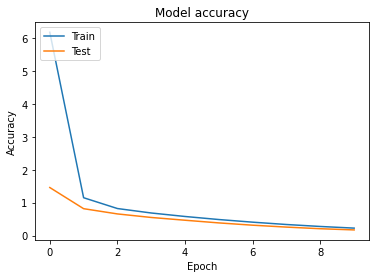

In [11]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# The user for whom we want to make recommendations
userNumber = 21

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
1146,1,163,5.0,Desperado (1995),0,136,4.873977
2426,1,356,4.0,Forrest Gump (1994),0,314,4.720941
0,1,1,4.0,Toy Story (1995),0,0,4.241548
267,1,6,4.0,Heat (1995),0,5,3.306679
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,3.122934
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,3.102667
2126,1,316,3.0,Stargate (1994),0,275,3.041546
1212,1,216,5.0,Billy Madison (1995),0,184,2.901730
2266,1,333,5.0,Tommy Boy (1995),0,291,2.755298
776,1,70,3.0,From Dusk Till Dawn (1996),0,62,2.750939


In [13]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
68924,22,1952,5.0,Midnight Cowboy (1969),21,1428,NaN,NaN
68946,22,1953,4.5,"French Connection, The (1971)",21,1429,NaN,NaN
68985,22,2160,4.0,Rosemary's Baby (1968),21,1615,NaN,NaN
69017,22,3006,4.0,"Insider, The (1999)",21,2263,NaN,NaN
69048,22,4017,4.0,Pollock (2000),21,2997,NaN,NaN


In [14]:
ratings[ratings.movieSeq == 520].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
